In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
main_path=os.getcwd()
print(main_path)

C:\Users\METE\Desktop\tfod_steel\workspace\training_demo


In [2]:
image_paths = []
for image_name in os.listdir("C:\\Users\\METE\\Desktop\\test_img"):
    image_paths.append(os.path.join("C:\\Users\\METE\\Desktop\\test_img", image_name))
print(image_paths)

['C:\\Users\\METE\\Desktop\\test_img\\2.jpg', 'C:\\Users\\METE\\Desktop\\test_img\\6.jpg', 'C:\\Users\\METE\\Desktop\\test_img\\bu_1.png', 'C:\\Users\\METE\\Desktop\\test_img\\ipn_1.png', 'C:\\Users\\METE\\Desktop\\test_img\\S-Beams-RSJ-IPN_260_260.jpg']


In [3]:
MODEL_DATE = '20221206'
MODEL_NAME = 'my_resnet'
LABEL_FILENAME = 'label_map.pbtxt'
PATH_TO_LABELS = os.path.join(main_path, "annotations", LABEL_FILENAME)
PATH_TO_MODEL_DIR = os.path.join(main_path, "models")
PATH_TO_CFG = os.path.join(PATH_TO_MODEL_DIR, "my_resnet", "pipeline.config" )
PATH_TO_CKPT = os.path.join(PATH_TO_MODEL_DIR, "my_resnet")

In [4]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.9280307292938232 seconds


In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [6]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

In [7]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

Running inference for C:\Users\METE\Desktop\test_img\2.jpg... Done
Running inference for C:\Users\METE\Desktop\test_img\6.jpg... Done
Running inference for C:\Users\METE\Desktop\test_img\bu_1.png... Done
Running inference for C:\Users\METE\Desktop\test_img\ipn_1.png... Done
Running inference for C:\Users\METE\Desktop\test_img\S-Beams-RSJ-IPN_260_260.jpg... Done


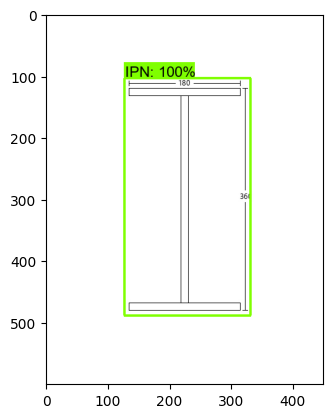

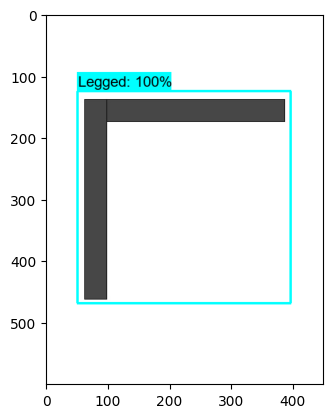

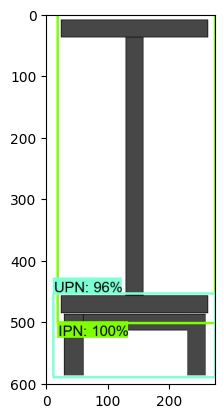

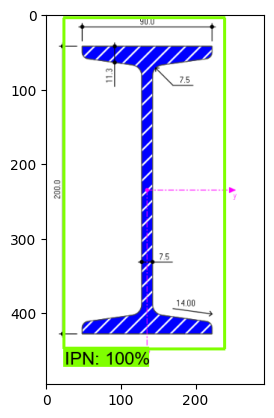

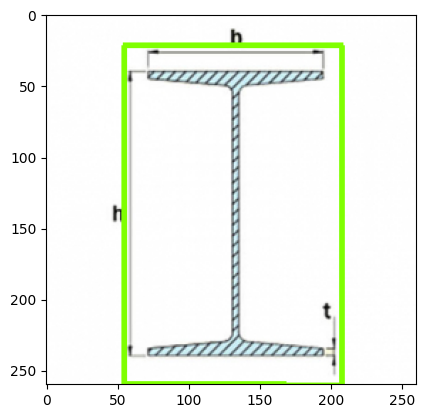

In [8]:
for image_path in image_paths:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2